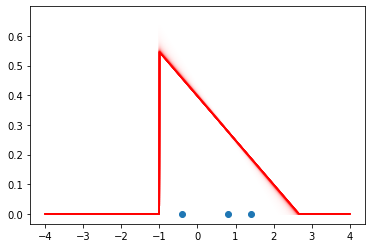

In [28]:
from torch.autograd import Function
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class Trapezoid(Function):

    @staticmethod
    def forward(ctx, start, end, slope, x):
        ctx.save_for_backward(start, end, slope, x)
        
        # bounded_slope = torch.tanh(slope) * (2 / (end - start) ** 2)
        bounded_slope = slope.clamp(-(2 / (end - start) ** 2), (2 / (end - start) ** 2))
        left_height = (1 - bounded_slope * (end - start) ** 2 / 2) / (end - start)
        output = left_height + bounded_slope * (x - start)

        return torch.where((start < x) & (x <= end), output, torch.zeros_like(x))

    @staticmethod
    def backward(ctx, grad_output):
        start, end, slope, x = ctx.saved_tensors
        # print(start,end,slope,x)

        # start gradient::: [MAPLE]
        t4 = torch.tanh(slope)
        t8 = -end + start
        t9 = t8 ** 2
        t12 = 0.1e1 / t9 / t8 * (t4 * (start + 0.3e1 * end - 0.4e1 * x) + start - 0.1e1 * end)
        grad_start = torch.where((start < x) & (x <= end), t12 * grad_output, 1e-5 * torch.sign(x - 0.5*(start+end)) * grad_output)

        # end gradient::: [MAPLE]
        t5 = torch.tanh(slope)
        t9 = -end + start
        t10 = t9 ** 2
        t13 = 0.1e1 / t10 / t9 * (t5 * (-0.3e1 * start - 0.1e1 * end + 0.4e1 * x) - 0.1e1 * start + end)
        grad_end = torch.where((start < x) & (x <= end), t13 * grad_output, 1e-5 * torch.sign(x - 0.5*(start+end)) * grad_output)

        
        # slope gradient::: [MAPLE]
        t3 = torch.cosh(slope)
        t4 = t3 ** 2
        t8 = (start - end) ** 2
        t10 = 0.1e1 / t8 / t4 * (-start - end + 0.2e1 * x)
        grad_slope = torch.where((start < x) & (x <= end), t10 * grad_output, torch.zeros_like(grad_output))
        
        # x gradient::: [MAPLE]
        grad_x = torch.where((start < x) & (x <= end), slope * grad_output, torch.sign(0.5*(start+end)-x) * grad_output)
        return grad_start, grad_end, grad_slope, grad_x
    
from matplotlib.colors import hsv_to_rgb


slope = nn.Parameter(torch.tensor(-4.0))
start = torch.tensor(-1.0, requires_grad=False)
end = torch.tensor(2.0, requires_grad=True)
params = [slope, start, end]

data = torch.tensor([-0.4, 0.8, 1.4])
xs = torch.linspace(0, 4, 1000)

epochs = 50
lr = 0.1
xs = torch.linspace(-4, 4, 1000)
for epoch in range(epochs):
    likelihood = torch.log(Trapezoid.apply(start, end, slope, data)).sum()

    with torch.no_grad():
        plt.plot(xs, Trapezoid.apply(start, end, slope, xs), c = hsv_to_rgb((1, ((epoch+1)/epochs)**2, 1)))
    
    likelihood.backward()
    for p in params:
        if p.grad is not None:
            p.data += lr * p.grad.clamp(-1, 1)
            p.grad.zero_()

plt.scatter(data, torch.zeros_like(data))

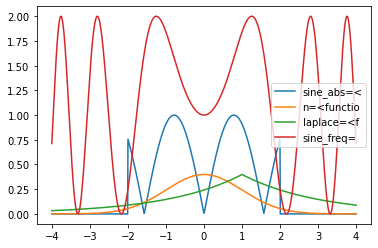

In [29]:
def sine_abs(a, b, c):
    return lambda x: torch.abs(torch.sin(c*x)) * (x > a) * (x < b)

def n(mean, sd):
    return lambda x: torch.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * torch.sqrt(2 * torch.tensor(3.1415)))

def laplace(p):
    return lambda x: torch.exp(-torch.abs(x - p) / 2) / torch.sqrt(2 * torch.tensor(3.1415))

def sine_freq(f):
    return lambda x: torch.sin(f*x**2) + 1

def inv(l):
    return lambda x: l/(x+0.1)


xs = torch.linspace(-4, 4, 1000)
plt.plot(xs, sine_abs(-2,2,2)(xs), label=f"{sine_abs=}"[:10])
plt.plot(xs, n(0,1)(xs), label=f"{n=}"[:10])
plt.plot(xs, laplace(1)(xs), label=f"{laplace=}"[:10])
plt.plot(xs, sine_freq(1)(xs), label=f"{sine_freq=}"[:10])
# plt.plot(xs, inv(1)(xs), label=f"{inv=}"[:10])
plt.legend()
ps = torch.linspace(-2, 2, 4+1, requires_grad=True)

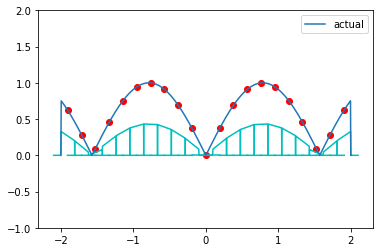

In [571]:
def discretize(pdf, bounds, n, normalize = True):
    """
    Parameters:
    pdf = lambda x: pdf(x)
    bounds = (start,end)
    n = number of trapezoids
    normalize = whether to normalize the weights to sum to 1
    
    
    Returns 
    
    [(a,b)], [(a+b)/2], [pdf((a+b)/2)], [pdf'((a+b)/2)], cdf(a < x <= b)
    
    n*[start and endpoint], n*[points between them], n*[the pdf of those evaluated at center], n*[the slope of the pdf at those points], n*[the cdf of the trapezoidal, aka. the weight]"""
    
    start, end = bounds

    xs = torch.linspace(start, end, n+1, requires_grad=True)

    offset = xs[1] - start
    mids = xs[:-1] + offset/2 # n midpoints
    mids.retain_grad()
    ys = pdf(mids)
    ab = torch.tensor(list(zip(xs[:-1], xs[1:])))
    widths = ab[:,1] - ab[:,0]
    weights = widths * ys
    ys.sum().backward(retain_graph=True)
    
    Z = 1
    if normalize:
        Z = weights.sum()
        weights = weights / Z

    slopes = mids.grad / (weights * Z)
    return ab, mids, ys, slopes, weights

scale = 1
func = lambda x: scale*sine_abs(-2,2,2)(x)

for (a, b), x, y, slope, w in zip(*discretize(func, bounds= (-2,2), n=21, normalize=True)):
    domain = torch.linspace(a-0.1, b+0.1, 100).detach()
    with torch.no_grad():
        plt.plot(domain, w * Trapezoid.apply(a, b, slope, domain),color = "c")
        plt.scatter([x], [y], color = "r")
xs = torch.linspace(-2, 2, 1000)
plt.plot(xs, func(xs), label= "actual")
plt.axis("equal")
plt.legend();

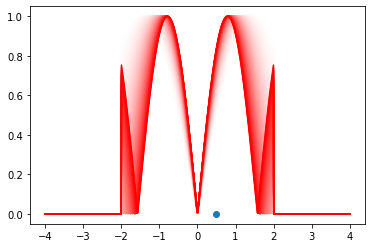

In [31]:
from matplotlib.colors import hsv_to_rgb

v = nn.Parameter(torch.ones(1))
data = torch.tensor([0.5])
epochs = 100
lr = 0.1
xs = torch.linspace(-4, 4, 1000)
for epoch in range(epochs):
    p = sine_abs(-2, 2, v)
    likelihood = torch.log(p(data))
    likelihood.backward()
    v.data += lr * v.grad.clamp(-1, 1) * 0.1

    with torch.no_grad():
        plt.plot(xs, p(xs), c = hsv_to_rgb((1, ((epoch+1)/epochs)**2, 1)))
    

plt.scatter(data, torch.zeros_like(data))

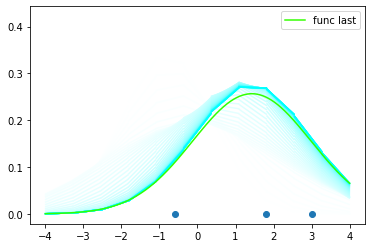

In [662]:
from matplotlib.colors import hsv_to_rgb

v = nn.Parameter(torch.tensor(1.0))
m1 = nn.Parameter(torch.tensor(-1.0))
m2 = nn.Parameter(torch.tensor(0.0))

data = torch.tensor([0.5, 0.3, -0.1]) * 6

params = [m1, m2]

# func = lambda x: 0.5 * n(m1, 1)(x) + 0.5 * n(m2,0.5)(x)

func = lambda x: n(m1, m2.exp())(x)

epochs = 50
for epoch in range(epochs):

    func = lambda xs: n(m1, m2.exp())(xs)

    likelihood = 0
    col = lambda h: hsv_to_rgb((h, ((epoch+1)/epochs)**2, 1))

    for (a, b), x, y, slope, w in zip(*discretize(func, bounds=(-4,4), n=11, normalize= True)):
        
        likelihood += (w * Trapezoid.apply(a.detach(), b.detach(), slope, data))
        
        with torch.no_grad():
            domain = torch.linspace(a+0.01, b-0.01, 100).detach()
            plt.plot(domain, w * Trapezoid.apply(a, b, slope, domain), color = col(0.5))

    
    likelihood.log().sum().backward()
    
    with torch.no_grad():
        if torch.norm(torch.stack([p.grad for p in params]), p=2).numpy().round(5) < 0.01:
            break
    
    for p in params:
        p.data += p.grad.clamp(-1, 1) * 0.1
        p.grad.zero_()


    # with torch.no_grad():
    #     xs = torch.linspace(-4, 4, 1000)
    #     plt.plot(xs, func(xs), color=col(1), label = "func" if epoch == epochs-1 else "", alpha = 1)    

    
with torch.no_grad():
    plt.plot(xs, func(xs), color=col(0.3), label = "func last", alpha = 1)    
plt.legend()
plt.scatter(data, torch.zeros_like(data), alpha=1, zorder= 10);